<a href="https://colab.research.google.com/github/marcusbrito/weather-station/blob/master/ts_inmet_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
import pandas as pd
import numpy as np
%matplotlib inline
import math

#Cleaning memory
import gc
gc.collect()

#Display all columns of dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [0]:
#uploaded = files.upload()
df = pd.read_csv("df_ecologia_agricola.csv", parse_dates=['date', 'mdct'])

In [0]:
df.head()

,Unnamed: 0,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,yr,mo,da,hr,prcp,stp,smax,smin,gbrd,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,5493152,371,ECOLOGIA AGRÍCOLA,35.0,-22.757868,-43.684843,A601,Seropédica,RJ,2000-05-24 00:00:00,2000-05-24,2000,5,24,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5493153,371,ECOLOGIA AGRÍCOLA,35.0,-22.757868,-43.684843,A601,Seropédica,RJ,2000-05-24 01:00:00,2000-05-24,2000,5,24,1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5493154,371,ECOLOGIA AGRÍCOLA,35.0,-22.757868,-43.684843,A601,Seropédica,RJ,2000-05-24 02:00:00,2000-05-24,2000,5,24,2,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5493155,371,ECOLOGIA AGRÍCOLA,35.0,-22.757868,-43.684843,A601,Seropédica,RJ,2000-05-24 03:00:00,2000-05-24,2000,5,24,3,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5493156,371,ECOLOGIA AGRÍCOLA,35.0,-22.757868,-43.684843,A601,Seropédica,RJ,2000-05-24 04:00:00,2000-05-24,2000,5,24,4,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **FEATURE ENGINEERING**

In [0]:
#Dropping not usefull columns

df.drop(df.iloc[:, 0:9], inplace = True, axis = 1) 
df.drop(df.iloc[:, 6:10], inplace = True, axis = 1) 
df.drop(df.iloc[:, -12:], inplace = True, axis = 1) 

In [0]:
#Adding day_of_year columns, as it may help the model with sazonality

df['day_of_year'] = df['date'].dt.dayofyear

In [0]:
df.tail()

,mdct,date,yr,mo,da,hr,gbrd,day_of_year
143371,2016-09-30 19:00:00,2016-09-30,2016,9,30,19,91.004,274
143372,2016-09-30 20:00:00,2016-09-30,2016,9,30,20,69.812,274
143373,2016-09-30 21:00:00,2016-09-30,2016,9,30,21,12.673,274
143374,2016-09-30 22:00:00,2016-09-30,2016,9,30,22,0.000,274
143375,2016-09-30 23:00:00,2016-09-30,2016,9,30,23,NaN,274


In [0]:
#Filling NaN with 0s

print(df.isnull().sum(axis = 0))
df.fillna(0, inplace=True)

mdct               0
date               0
yr                 0
mo                 0
da                 0
hr                 0
gbrd           60848
day_of_year        0
dtype: int64


In [0]:
#Adding past values as features

PAST_WINDOW = 48

#Lag
for i in range(1,PAST_WINDOW):
  df[f'rad_t-{i}'] = df['gbrd'].shift(i)

#Lag difference
for i in range(1,PAST_WINDOW):
  df[f'rad_diff_{i}'] = df['gbrd'].diff(i)

#Moving averages
df[f'rad_mov_avg_{PAST_WINDOW}'] = df['gbrd'].rolling(PAST_WINDOW).mean()
df[f'rad_mov_avg_{PAST_WINDOW/2}'] = df['gbrd'].rolling(round(PAST_WINDOW/2), 0).mean()

In [0]:
#Creating targets - Radiation for the next 24h

for i in range(1,25):
  df[f'rad_future_{i}'] = df['gbrd'].shift(-i)

In [0]:
#Renaming radiation columns, only because it will be easier to manipulate

df.rename(columns={'gbrd' : 'rad_t-0'}, inplace=True)

In [0]:
#Spliting dataset from training and testing

df_train = df[df['date'] < "2012-01-01"].copy()
df_test = df[df['date'] >= "2012-01-01"].copy()

df_train.shape, df_test.shape

((101736, 128), (41640, 128))

In [0]:
#Dropping date columns

df_train.drop(['mdct','date'], axis=1, inplace=True)
df_test.drop(['mdct','date'], axis=1, inplace=True)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [0]:
#Separating Features and Labels

x_train, y_train = (df_train.drop([f'rad_future_{i}' for i in range(1,25)], axis=1), df_train[[f'rad_future_{i}' for i in range(1,25)]])
x_test, y_test = (df_test.drop([f'rad_future_{i}' for i in range(1,25)], axis=1), df_test[[f'rad_future_{i}' for i in range(1,25)]])


In [0]:
x_train.head()

,yr,mo,da,hr,rad_t-0,day_of_year,rad_t-1,rad_t-2,rad_t-3,rad_t-4,rad_t-5,rad_t-6,rad_t-7,rad_t-8,rad_t-9,rad_t-10,rad_t-11,rad_t-12,rad_t-13,rad_t-14,rad_t-15,rad_t-16,rad_t-17,rad_t-18,rad_t-19,rad_t-20,rad_t-21,rad_t-22,rad_t-23,rad_t-24,rad_t-25,rad_t-26,rad_t-27,rad_t-28,rad_t-29,rad_t-30,rad_t-31,rad_t-32,rad_t-33,rad_t-34,rad_t-35,rad_t-36,rad_t-37,rad_t-38,rad_t-39,rad_t-40,rad_t-41,rad_t-42,rad_t-43,rad_t-44,rad_t-45,rad_t-46,rad_t-47,rad_diff_1,rad_diff_2,rad_diff_3,rad_diff_4,rad_diff_5,rad_diff_6,rad_diff_7,rad_diff_8,rad_diff_9,rad_diff_10,rad_diff_11,rad_diff_12,rad_diff_13,rad_diff_14,rad_diff_15,rad_diff_16,rad_diff_17,rad_diff_18,rad_diff_19,rad_diff_20,rad_diff_21,rad_diff_22,rad_diff_23,rad_diff_24,rad_diff_25,rad_diff_26,rad_diff_27,rad_diff_28,rad_diff_29,rad_diff_30,rad_diff_31,rad_diff_32,rad_diff_33,rad_diff_34,rad_diff_35,rad_diff_36,rad_diff_37,rad_diff_38,rad_diff_39,rad_diff_40,rad_diff_41,rad_diff_42,rad_diff_43,rad_diff_44,rad_diff_45,rad_diff_46,rad_diff_47,rad_mov_avg_48,rad_mov_avg_24.0
47,2000,5,25,23,0.0,146,0.0,5.0,320.0,1071.0,1724.0,2212.0,2493.0,2529.0,2298.0,1889.0,1284.0,569.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-320.0,-1071.0,-1724.0,-2212.0,-2493.0,-2529.0,-2298.0,-1889.0,-1284.0,-569.0,-38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342.458333,684.666667
48,2000,5,26,0,0.0,147,0.0,0.0,5.0,320.0,1071.0,1724.0,2212.0,2493.0,2529.0,2298.0,1889.0,1284.0,569.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-320.0,-1071.0,-1724.0,-2212.0,-2493.0,-2529.0,-2298.0,-1889.0,-1284.0,-569.0,-38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342.458333,684.666667
49,2000,5,26,1,0.0,147,0.0,0.0,0.0,5.0,320.0,1071.0,1724.0,2212.0,2493.0,2529.0,2298.0,1889.0,1284.0,569.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-320.0,-1071.0,-1724.0,-2212.0,-2493.0,-2529.0,-2298.0,-1889.0,-1284.0,-569.0,-38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342.458333,684.666667
50,2000,5,26,2,0.0,147,0.0,0.0,0.0,0.0,5.0,320.0,1071.0,1724.0,2212.0,2493.0,2529.0,2298.0,1889.0,1284.0,569.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-320.0,-1071.0,-1724.0,-2212.0,-2493.0,-2529.0,-2298.0,-1889.0,-1284.0,-569.0,-38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342.458333,684.666667
51,2000,5,26,3,0.0,147,0.0,0.0,0.0,0.0,0.0,5.0,320.0,1071.0,1724.0,2212.0,2493.0,2529.0,2298.0,1889.0,1284.0,569.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-320.0,-1071.0,-1724.0,-2212.0,-2493.0,-2529.0,-2298.0,-1889.0,-1284.0,-569.0,-38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342.458333,684.666667


# **MODELING**

In [0]:
from sklearn.metrics import mean_squared_log_error
from sklearn.multioutput import MultiOutputRegressor

In [0]:
#Creating baseline - Repeating last 24 hours

pred_baseline = np.array([x_test[f'rad_t-{i}'] for i in range(23,-1,-1)]).transpose()
print('Baseline error: ', np.sqrt(mean_squared_log_error(pred_baseline, y_test)))

Baseline error:  0.6479425803755527


In [0]:
#Simple random forest

from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=300)
model_rf.fit(x_train, y_train)
pred_rf = model_rf.predict(x_test)
print('Random Forest error: ', np.sqrt(mean_squared_log_error(y_test, pred)))

KeyboardInterrupt: ignored

In [0]:
#XGBoost

from xgboost import XGBRegressor

model_xgb = MultiOutputRegressor(XGBRegressor())
model_xgb.fit(x_train, y_train)
pred_xgb = model_xgb.predict(x_test)
pred_xgb[pred_xgb < 0] = 0
print('XGBoost error: ', np.sqrt(mean_squared_log_error(y_test, pred_xgb)))

In [0]:
#LightGBM

from lightgbm import LGBMRegressor

model_light = MultiOutputRegressor(LGBMRegressor())
model_light.fit(x_train, y_train)
pred_light = model_light.predict(x_test)
pred_light[pred_light < 0] = 0
print('LightGBM error: ', np.sqrt(mean_squared_log_error(y_test, pred_light)))

LightGBMError: ignored

In [0]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).seconds)):
        yield start_date + timedelta(n)

start_date = date(2016, 9, 24)
end_date = date(2016, 9, 29)
for single_date in daterange(start_date, end_date):
    print(single_date.strftime("%Y-%m-%d"))


In [0]:
from fbprophet import Prophet

PROPHET_PAST_WINDOW = 30

df_prophet = df[['mdct','rad_t-0']].copy()
df_prophet.columns = ['ds', 'y']

df_prophet_test = df_prophet[df_prophet['ds'] >= "2012-01-01"].copy()

pred_prophet_full = []
i = 0
for end_date in df_prophet_test['ds'].values:

  start_date = end_date - np.timedelta64(PROPHET_PAST_WINDOW,'D')

  prophet = Prophet()

  prophet.fit(df_prophet[(df_prophet['ds'] > start_date) & (df_prophet['ds'] <= end_date)])

  df_profet_future = prophet.make_future_dataframe(24, include_history=False, freq='H')
  pred_prophet = prophet.predict(df_profet_future)

  pred_prophet[pred_prophet['yhat'] < 0] = 0
  pred_prophet_full.append(pred_prophet['yhat'].values)
  if i == 1000:
    break
  i += 1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

In [0]:
y_test.shape

(41616, 24)

In [0]:
print('LightGBM error: ', np.sqrt(mean_squared_log_error(y_test[:1001], pred_prophet_full)))

LightGBM error:  2.8928042357469526


In [0]:
print(pred_prophet_full[0])

[   0.            0.            0.            0.            0.
    0.            0.            0.            0.           73.80217066
  533.99129235 1000.26186059 1356.61669781 1559.99990235 1628.82740376
 1584.41436732 1413.53134027 1093.09827171  648.98005931  181.04423391
    0.            0.            0.            0.        ]


In [0]:
print(y_test.values[0])

[   0.       0.       0.       0.       0.       0.       0.       0.
   26.983  172.946  500.297 1076.301 1237.06   583.736  447.336  311.6
  538.788  598.57   778.235  310.45   129.765    7.987    0.       0.   ]


# **ANALYZING RESULTS**

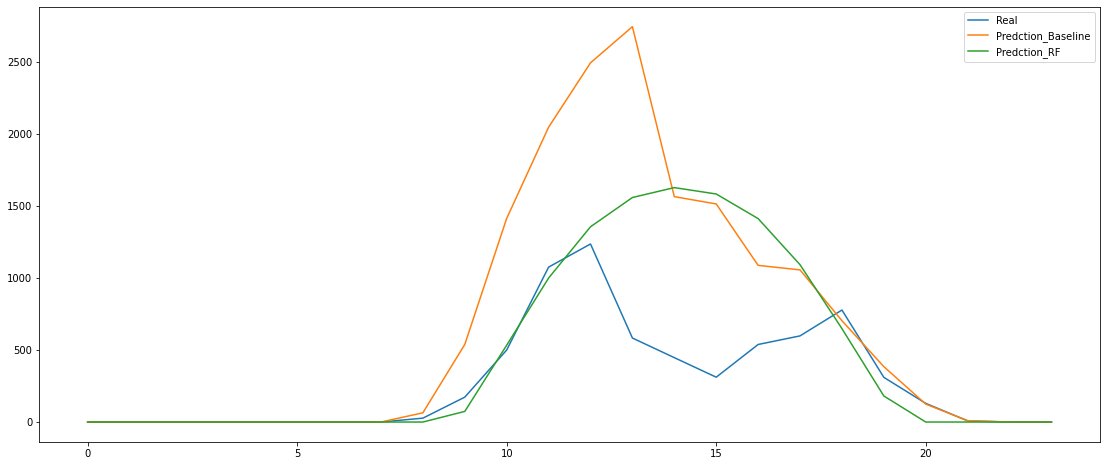

In [0]:
import matplotlib.pyplot as plt

test_hour = 0
plt.rcParams['figure.figsize'] = [19, 8]
plt.plot(y_test.values[test_hour])
plt.plot(pred_baseline[test_hour])
#plt.plot(pred_rf[test_hour])
#plt.plot(pred_xgb[test_hour])
#plt.plot(pred_light[test_hour])
plt.plot(pred_prophet_full[test_hour])
plt.legend(['Real', 'Predction_Baseline', 'Predction_RF', 'Predction_XGBoost', 'Predction_LightGBM'])
plt.show()

In [0]:
x_test.tail()

,yr,mo,da,hr,rad_t-0,day_of_year,rad_t-1,rad_t-2,rad_t-3,rad_t-4,rad_t-5,rad_t-6,rad_t-7,rad_t-8,rad_t-9,rad_t-10,rad_t-11,rad_t-12,rad_t-13,rad_t-14,rad_t-15,rad_t-16,rad_t-17,rad_t-18,rad_t-19,rad_t-20,rad_t-21,rad_t-22,rad_t-23,rad_t-24,rad_t-25,rad_t-26,rad_t-27,rad_t-28,rad_t-29,rad_t-30,rad_t-31,rad_t-32,rad_t-33,rad_t-34,rad_t-35,rad_t-36,rad_t-37,rad_t-38,rad_t-39,rad_t-40,rad_t-41,rad_t-42,rad_t-43,rad_t-44,rad_t-45,rad_t-46,rad_t-47,rad_diff_1,rad_diff_2,rad_diff_3,rad_diff_4,rad_diff_5,rad_diff_6,rad_diff_7,rad_diff_8,rad_diff_9,rad_diff_10,rad_diff_11,rad_diff_12,rad_diff_13,rad_diff_14,rad_diff_15,rad_diff_16,rad_diff_17,rad_diff_18,rad_diff_19,rad_diff_20,rad_diff_21,rad_diff_22,rad_diff_23,rad_diff_24,rad_diff_25,rad_diff_26,rad_diff_27,rad_diff_28,rad_diff_29,rad_diff_30,rad_diff_31,rad_diff_32,rad_diff_33,rad_diff_34,rad_diff_35,rad_diff_36,rad_diff_37,rad_diff_38,rad_diff_39,rad_diff_40,rad_diff_41,rad_diff_42,rad_diff_43,rad_diff_44,rad_diff_45,rad_diff_46,rad_diff_47,rad_mov_avg_48,rad_mov_avg_24.0
143347,2016,9,29,19,1570.478,273,2439.210,2955.037,3297.182,2934.999,2867.573,2493.569,1940.528,1223.524,432.946,16.970,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.211,817.332,1673.979,2497.898,2914.903,3005.264,2124.974,2327.462,1932.960,807.852,362.270,111.852,3.304,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.411,329.445,-868.732,-1384.559,-1726.704,-1364.521,-1297.095,-923.091,-370.050,346.954,1137.532,1553.508,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1453.267,753.146,-103.501,-927.420,-1344.425,-1434.786,-554.496,-756.984,-362.482,762.626,1208.208,1458.626,1567.174,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1570.478,1485.067,1241.033,860.086104,962.773292
143348,2016,9,29,20,853.339,273,1570.478,2439.210,2955.037,3297.182,2934.999,2867.573,2493.569,1940.528,1223.524,432.946,16.970,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,117.211,817.332,1673.979,2497.898,2914.903,3005.264,2124.974,2327.462,1932.960,807.852,362.270,111.852,3.304,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,85.411,-717.139,-1585.871,-2101.698,-2443.843,-2081.660,-2014.234,-1640.230,-1087.189,-370.185,420.393,836.369,853.339,853.339,853.339,853.339,853.339,853.339,853.339,853.339,853.339,853.339,853.339,736.128,36.007,-820.640,-1644.559,-2061.564,-2151.925,-1271.635,-1474.123,-1079.621,45.487,491.069,741.487,850.035,853.339,853.339,853.339,853.339,853.339,853.339,853.339,853.339,853.339,853.339,853.339,767.928,871.000562,964.273583
143349,2016,9,29,21,134.487,273,853.339,1570.478,2439.210,2955.037,3297.182,2934.999,2867.573,2493.569,1940.528,1223.524,432.946,16.970,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,117.211,817.332,1673.979,2497.898,2914.903,3005.264,2124.974,2327.462,1932.960,807.852,362.270,111.852,3.304,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,-718.852,-1435.991,-2304.723,-2820.550,-3162.695,-2800.512,-2733.086,-2359.082,-1806.041,-1089.037,-298.459,117.517,134.487,134.487,134.487,134.487,134.487,134.487,134.487,134.487,134.487,134.487,134.487,17.276,-682.845,-1539.492,-2363.411,-2780.416,-2870.777,-1990.487,-2192.975,-1798.473,-673.365,-227.783,22.635,131.183,134.487,134.487,134.487,134.487,134.487,134.487,134.487,134.487,134.487,134.487,134.487,872.022979,964.993417
143350,2016,9,29,22,0.000,273,134.487,853.339,1570.478,2439.210,2955.037,3297.182,2934.999,2867.573,2493.569,1940.528,1223.524,432.946,16.970,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,117.211,817.332,1673.979,2497.898,2914.903,3005.264,2124.974,2327.462,1932.960,807.852,362.270,111.852,3.304,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,-134.487,-853.339,-1570.478,-2439.210,-2955.037,-3297.182,-2934.999,-2867.573,-2493.569,-1940.528,-1223.524,-432.946,-16.970,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-117.211,-817.332,-1673.979,-2497.898,-2914.903,-3005.264,-2124.974,-2327.462,-